In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np

In [3]:
start_frame = 8500
nframes = 222788
ratio = start_frame / nframes
print(ratio)
nseconds = 3949
seconds = nseconds * ratio
hours = int(seconds // 3600)
rem = seconds % 3600
minutes = int(rem // 60)
secs = int(rem % 60)
print(f"{hours}:{minutes}:{secs}")
frame_factor = 5

0.038152862811282474
0:2:30


In [4]:
f = open("abstraction_validation/ram.bin", "rb")
frame_size = 0x2000

In [5]:
ram_data = np.memmap("abstraction_validation/ram.bin", dtype="int16", mode="c").reshape((-1, frame_size // 2))
ram_data_int8 = np.memmap("abstraction_validation/ram.bin", dtype="uint8", mode="c").reshape((-1, frame_size))
#ram_data_offset = np.np.memmap("Bizhawk-2.2.2/lsnes/ram.bin", dtype="uint8").reshape((-1, frame_size))
print(ram_data.shape)
print(ram_data_int8.shape)

(222788, 4096)
(222788, 8192)


In [6]:
f.seek(frame_size * start_frame)
frame_bytes = f.read(frame_size)

In [7]:
def hex_str(b):
    return " ".join(hex(x) for x in b)

In [8]:
# Room Pointer
print(hex_str(frame_bytes[0x079b:0x079d]))
# Room Index
print(frame_bytes[0x079d:0x079f])
# Area Index
print(frame_bytes[0x079f:0x07a0])

0x45 0xdf
b'\x00\x00'
b'\x06'


In [9]:
# Level Data Pointer
print(frame_bytes[0x07bd:0x07c0])
print([hex(x) for x in list(frame_bytes[0x07bd:0x07c0])])

b'F\xb8\xcd'
['0x46', '0xb8', '0xcd']


In [10]:
# Samus X, Y
samus_x = frame_bytes[0x0af6:0x0af8]
samus_y = frame_bytes[0x0afa:0x0afc]

In [11]:
samus_x = int.from_bytes(samus_x, byteorder="little") // 16
samus_y = int.from_bytes(samus_y, byteorder="little") // 16

In [12]:
samus_y

32

In [13]:
frame_bytes[0x0af6:0x0af8]

b'\xab\x00'

In [14]:
print(frame_bytes[0x07a1:0x07a3])
int.from_bytes(frame_bytes[0x07a1:0x07a3], byteorder="little")
print(frame_bytes[0x07a3:0x07a5])
int.from_bytes(frame_bytes[0x07a3:0x07a5], byteorder="little")
print(frame_bytes[0x0998:0x099a])

b'\x0c\x00'
b'\r\x00'
b'\x08\x00'


In [15]:
data_all = ram_data[start_frame::frame_factor, :]
data_int8_all = ram_data_int8[start_frame::frame_factor, :]
#
gamestate_8 = data_all[:, 0x998 // 2] == 8
# Filter by gamestate = 8 - Apparently this is valid numpy syntax
data = data_all[gamestate_8, :]
data_int8 = data_int8_all[gamestate_8, :]
# Map x,y
print(hex(data_int8[0, 0x07a1]))
print(hex(data_int8[0, 0x07a3]))
# Region index
print(hex(data_int8[0, 0x79f]))
#data[0, 0x07a3 // 2] >> 8
#[2:00 PM] P.JBoy: I would maybe only run the tracker when the gamestate = 8
#[2:00 PM] Aremath: yeah
#[2:01 PM] P.JBoy: possibly C/D/11/12 for pause screen transitions

0xc
0xd
0x6


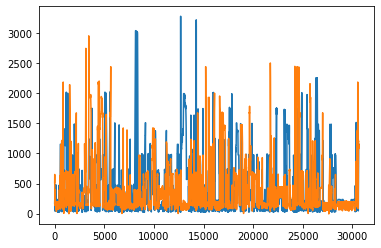

In [16]:
maptile_size = 256
#xs = ram_data[100000:110000,0x0af6] + 256 * ram_data[100000:110000,0x0af7]
#data = ram_data[start_frame::5, :]
#def get_int(address):
#    return data[:, address] + 256 * data[:, address + 1]
#    #return data[:, address:address+2].view("int16")
#xs = get_int(0x0af6)
#ys = get_int(0x0afa)
xs = data[:, 0x0af6 // 2]
ys = data[:, 0x0afa // 2]
map_xs = maptile_size * data_int8[:, 0x07a1]
map_ys = maptile_size * data_int8[:, 0x07a3]
#xs = ram_data[100000:110000,0x0af6 // 2]
#ys = ram_data[100000:110000,0x0afa] + 256 * ram_data[100000:110000,0x0afb]
#ys = ram_data[100000:110000,0x0afa // 2]
plot(xs)
plot(ys)
# Filter xs
#xs[xs > 1000] = 0
#ys[ys > 1000] = 0

In [17]:
#$079F: Area index
#{
#    0: Crateria
#    1: Brinstar
#    2: Norfair
#    3: Wrecked Ship
#    4: Maridia
#    5: Tourian
#    6: Ceres
#    7: Debug
#}
area_offsets = {
    0: (3, 10),
    1: (0, 29),
    2: (31, 49),
    #2: (31, 61),
    #3: (40, 0),
    3: (37, 0),
    #4: (29, 29),
    4: (28, 29),
    5: (0, 10),
    # Out of bounds
    6: (0, -10),
    7: (0, 0),
}
area_lookup_x = numpy.vectorize(lambda x: area_offsets[x][0])
area_lookup_y = numpy.vectorize(lambda x: area_offsets[x][1])
area_xs = maptile_size * area_lookup_x(data_int8[:, 0x79f])
area_ys = maptile_size * area_lookup_y(data_int8[:, 0x79f])

In [18]:
colorspace = np.linspace(0, 1, xs.size)
#colors = [plt.cm.viridis(x) for x in colorspace]
#colors = [plt.cm.gist_ncar(x) for x in colorspace]
colors = [plt.cm.nipy_spectral(x) for x in colorspace]

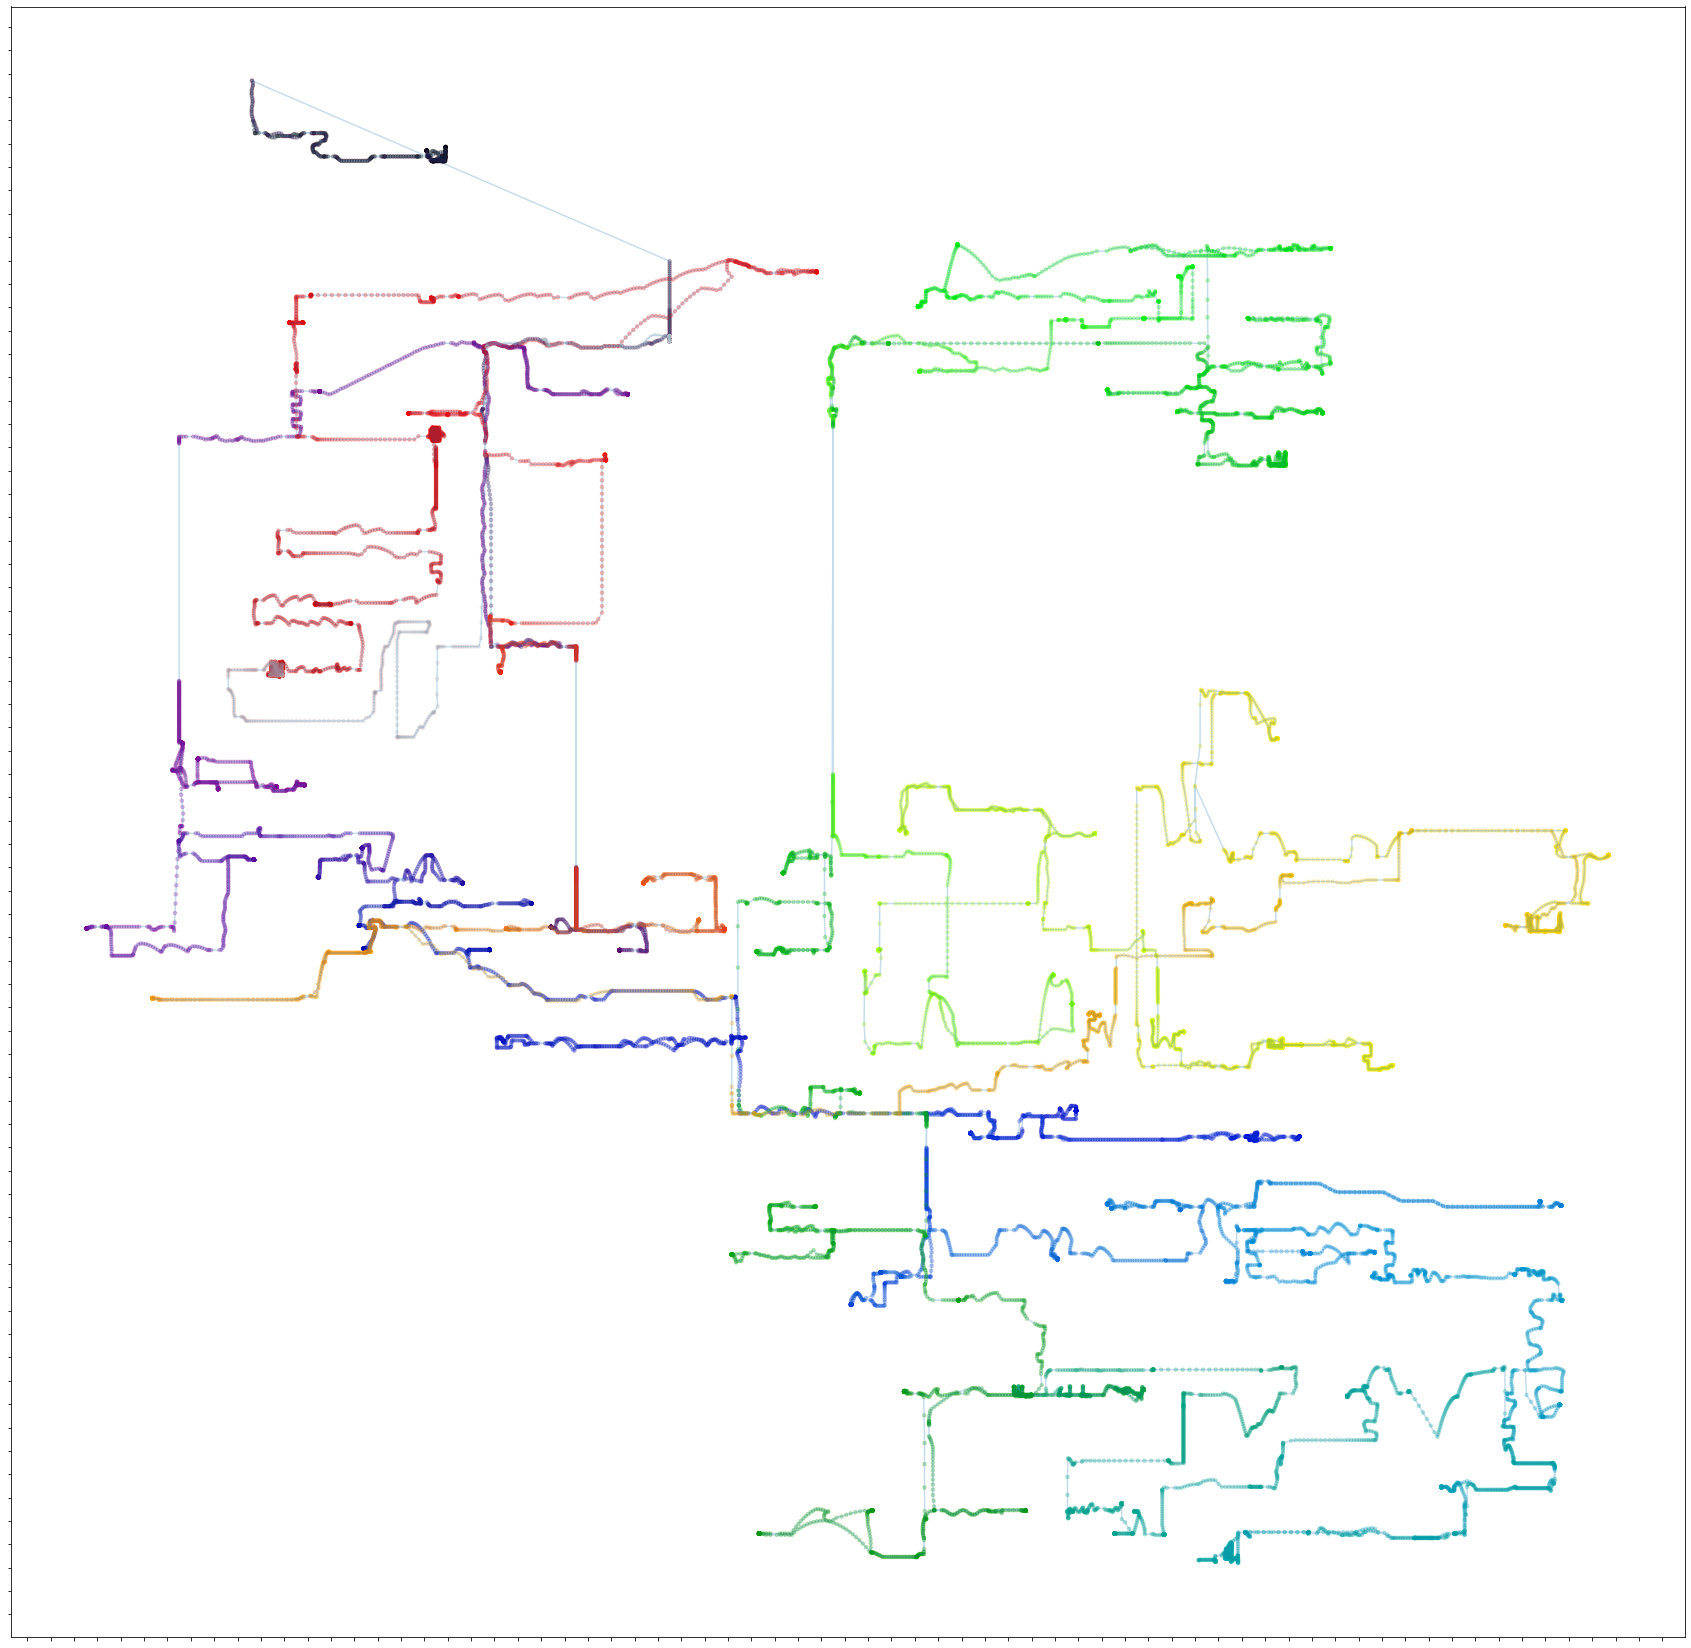

In [19]:
figure(figsize=(30,30))
#img = "SuperMetroidMapZebes.png"
#img = plt.img
#scatter(xs + map_xs, -ys - map_ys, alpha=0.1, s=1)
scatter(xs + map_xs + area_xs, -ys - map_ys - area_ys, alpha=0.25, color=colors, s=12)
plot(xs + map_xs + area_xs, -ys - map_ys - area_ys, alpha=0.25)
axes = gca()
major_xticks = np.arange(0, maptile_size * 200, maptile_size)
major_yticks = -np.arange(0, maptile_size * 200, maptile_size)
plt.xticks(major_xticks)
plt.yticks(major_yticks)
#axes.xaxis.set_ticks(major_ticks)
axes.xaxis.set_ticklabels([])
#axes.yaxis.set_ticks(major_ticks)
axes.yaxis.set_ticklabels([])
#axes.grid(which="major", color="r", linestyle="-", alpha=0.5)
#axes.grid(axis="both")
axes.axis("equal")
#colorbar()
#plot(xs, -ys, alpha=0.1)
plt.show()

In [20]:
ram_data.shape

(222788, 4096)

## Abstractify state to within room model

In [21]:
from data_types import item_set
from world_rando.rules import SamusState, SamusPose, Velocity, VType, HVelocity
from world_rando.coord import Coord

In [22]:
item_bits = {
    0x1 : "V",
    0x2 : "SPB",
    0x4 : "MB",
    0x8 : "SA",
    0x20 : "GS",
    0x100 : "HJ",
    0x200 : "SJ",
    0x1000 : "B",
    0x2000 : "SB",
    0x4000 : "G",
    0x8000 : "XR"
}

beam_bits = {
    0x1 : "WB",
    0x2 : "IB",
    0x4 : "Spazer",
    0x8 : "PLB",
    0x1000 : "CB"
}

def from_bitflag(flag, flag_dict):
    items = []
    for k,v in flag_dict.items():
        if flag & k:
            items.append(v)
    return item_set.ItemSet(items)

#TODO: bosses defeated - info not obtained by current data collection!
#         $7E:D828..2F: Boss bits. Indexed by area
#        {
#            1: Area boss (Kraid, Phantoon, Draygon, both Ridleys)
#            2: Area mini-boss (Spore Spawn, Botwoon, Crocomire, Mother Brain)
#            4: Area torizo (Bomb Torizo, Golden Torizo)
#        }    

In [23]:
data.shape

(30671, 4096)

In [24]:
print(from_bitflag(data[5000, 0x09a4//2], item_bits))
print(from_bitflag(data[5000, 0x09a8//2], beam_bits))

ISet(['B', 'MB'])
ISet(['CB'])


In [25]:
def abstractify_items(frame):
    items = from_bitflag(frame[0x09a4 // 2], item_bits)
    beams = from_bitflag(frame[0x09a8 // 2], beam_bits)
    all_items = items | beams
    n_ammo = 0
    # Missiles
    max_missiles = frame[0x09c8 // 2]
    n_ammo += max_missiles // 5
    if max_missiles > 0:
        all_items = all_items.add("M")
    # Supers
    max_supers = frame[0x09cc // 2]
    n_ammo += max_supers // 5
    if max_supers > 0:
        all_items = all_items.add("S")
    # PBs
    max_pbs = frame[0x09ce // 2]
    n_ammo += max_pbs // 5
    if max_pbs > 0 :
        all_items = all_items.add("PB")
    # Etanks
    max_energy = frame[0x09c4 // 2]
    n_ammo += (max_energy - 99) // 100
    if max_energy > 99:
        all_items = all_items.add("E")
    return all_items, n_ammo

In [26]:
abstractify_items(data[5000, :])

(ISet(['B', 'PB', 'S', 'M', 'MB', 'CB', 'E']), 13)

In [27]:
for s in set(data[:, 0x0b00 // 2]):
    print(hex(s))
# normal - 0x15 -> 21
# standard jump - 0x13 -> 19
# standard jump facing down - 0x0a -> 10
# spin jump - 0x0c -> 12
# crouch - 0x10
# morph - 0x7

0x0
0x7
0xa
0xc
0x10
0x11
0x13
0x15
0x18


In [28]:
def abstractify_pos_pose(frame):
    # Compute Abstract position
    x_center = frame[0x0af6 // 2]
    y_center = frame[0x0afa // 2]
    x_radius = frame[0x0afe // 2]
    y_radius = frame[0x0b00 // 2]
    top = (y_center - y_radius) // 16
    left = (x_center - x_radius) // 16
    pos = Coord(left, top)
    # Compute abstract pose
    if y_radius <= 0x7:
        pose = SamusPose.MORPH
    elif y_radius == 0x0a:
        pose = SamusPose.JUMP
    elif y_radius == 0x0c:
        pose = SamusPose.SPIN
    #TODO! Add Crouch pose & rules
    elif y_radius == 0x10:
        pose = SamusPose.MORPH
    #TODO: unknown pose
    elif y_radius == 0x11:
        pose = SamusPose.MORPH
    elif y_radius == 0x13:
        pose = SamusPose.JUMP
    elif y_radius == 0x15:
        pose = SamusPose.STAND
    #TODO: unknown pose
    elif y_radius == 0x18:
        pose = SamusPose.STAND
    return pos, pose
    
#TODO
def abstractify_velocity(frame):
    hvel = HVelocity(VType.RUN, 0)
    vvel = 0
    return Velocity(vvel, hvel)

In [29]:
def abstractify_state(frame):
    pos, pose = abstractify_pos_pose(frame)
    v = abstractify_velocity(frame)
    items = abstractify_items(frame)
    return SamusState(pos, v, items, pose)

In [30]:
state1 = abstractify_state(data[4900, :])
state2 = abstractify_state(data[5000, :])

In [31]:
print(hex(data[4900, 0x79b // 2]))
print(hex(data[5000, 0x79b // 2]))

0x5200
0x5200


## Abstractify state to room model

In [32]:
from encoding import parse_rooms, sm_global
from data_types.constraintgraph import ConstraintGraph, BFSState, bfs_backtrack

In [40]:
rooms = parse_rooms.parse_rooms("encoding/dsl/rooms_base_abstraction.txt")
rooms.pop("Kraid2")
rooms.pop("Phantoon2")
rooms.pop("Draygon2")
rooms.pop("Ridley2")

In [41]:
room_ref = {room.mem_address & 0xffff : room for room in rooms.values()}

In [42]:
def parse_exits(exits_file):
    out = []
    f = open(exits_file, "r")
    for line in f.readlines():
        line = line.strip()
        if line[0] == "#":
            continue
        door_a, door_b = line.split("<>")
        door_a = door_a.strip()
        door_b = door_b.strip()
        out.append((door_a, door_b))
    return out

In [43]:
exits = parse_exits("encoding/dsl/exits.txt")

In [44]:
def build_base_abstraction(rooms, exits):
    g = ConstraintGraph()
    for room in rooms.values():
        g.add_subgraph(room.graph)
    for door1, door2 in exits:
        print(door1, door2)
        g.connect_doors(door1, door2)
    return g

In [45]:
base_abs = build_base_abstraction(rooms, exits)

Landing_Site_L2 Parlor_R1
Landing_Site_L1 Gauntlet_Entrance_R
Landing_Site_R1 Crateria_Power_Bombs_L
Parlor_L2 Parlor_Save_Room_R
Bowling_Path_L West_Ocean_R3
Bowling_Path_R Ocean_Ship_Trans_L
East_Ocean_R Forgotten_Highway_L
East_Ocean_L Electric_Room_of_Death_R
Forgotten_Highway_B Crab_Maze_T
Crab_Maze_L Crateria_Power_Door_R
Crateria_Power_Door_B Crateria_Maridia_Shaft_T
Crateria_Tube_L Landing_Site_R2
Crateria_Tube_R Crateria_Kihunters_L
Crateria_Kihunters_R Moat_L
Moat_R West_Ocean_L2
Crateria_Kihunters_B Caterpillar_Elevator_T
Gauntlet_Entrance_L Gauntlet_R
West_Ocean_R6 Wrecked_Ship_Entrance_L
Parlor_B Climb_Room_T
Old_Mother_Brain_L Climb_Room_R3
Blue_Brinstar_Elevator_L Old_Mother_Brain_R
BT_Flyway_R Bomb_Torizo_L
BT_Flyway_L Parlor_R2
Map_Flyway_L Parlor_R3
Terminator_Room_R Parlor_L1
Kago_Room_L Brinstar_Elevator_R
Crateria_Map_L Map_Flyway_R
Gauntlet_L Green_Pirates_Shaft_R1
Terminator_Room_L Green_Pirates_Shaft_R2
Kago_Room_R Green_Pirates_Shaft_L
Crateria_Supers_L1 Climb_

In [89]:
start = BFSState("Ceres_Entrance_T")
end = BFSState("Mother_Brain_L") # >= will take care of items requirements
#end = BFSState("Landing_Site_L2")

In [90]:
offers, finished, _, final_state = base_abs.BFS_optimized(start, end)

10000
Green_Hill_Zone_M
ISet(['B', 'PB', 'S', 'M', 'HJ', 'MB', 'Spazer', 'Ceres_Ridley'])

20000
Parlor_R2
ISet(['B', 'PB', 'S', 'M', 'HJ', 'MB', 'CB', 'E', 'Spazer', 'RT', 'Ceres_Ridley'])

30000
Climb_Room_T
ISet(['B', 'PB', 'S', 'M', 'HJ', 'MB', 'CB', 'Kraid', 'Ceres_Ridley'])

40000
Spazer_Troll_R1
ISet(['B', 'PB', 'S', 'M', 'V', 'HJ', 'MB', 'CB', 'RT', 'IB', 'Kraid', 'Ceres_Ridley'])

50000
Ice_Beam_Gate_L2
ISet(['B', 'PB', 'S', 'M', 'V', 'SB', 'MB', 'CB', 'E', 'RT', 'XR', 'Kraid', 'Ceres_Ridley'])

60000
Parlor_B
ISet(['B', 'PB', 'S', 'M', 'V', 'HJ', 'MB', 'CB', 'E', 'Spazer', 'XR', 'Kraid', 'Ceres_Ridley'])

70000
Crab_Tunnel_L
ISet(['B', 'PB', 'S', 'M', 'V', 'HJ', 'MB', 'CB', 'E', 'Spazer', 'RT', 'XR', 'IB', 'Kraid', 'Ceres_Ridley'])

80000
Wrecked_Ship_Supers_S
ISet(['B', 'PB', 'S', 'M', 'V', 'HJ', 'MB', 'CB', 'XR', 'Kraid', 'Phantoon', 'Ceres_Ridley'])

90000
Map_Flyway_R
ISet(['B', 'PB', 'S', 'M', 'GS', 'MB', 'CB', 'E', 'Kraid', 'Phantoon', 'Ceres_Ridley'])

100000
Spore_Spa

650000
Terminator_Room_E
ISet(['B', 'PB', 'S', 'M', 'G', 'V', 'GS', 'SB', 'HJ', 'MB', 'CB', 'RT', 'XR', 'Kraid', 'Phantoon', 'Ceres_Ridley'])

660000
Blue_Brinstar_Elevator_ET
ISet(['B', 'PB', 'S', 'M', 'G', 'V', 'HJ', 'MB', 'CB', 'RT', 'XR', 'IB', 'Kraid', 'Phantoon', 'Ceres_Ridley'])

670000
Main_Street_B
ISet(['B', 'PB', 'S', 'M', 'G', 'SA', 'V', 'GS', 'MB', 'CB', 'WB', 'E', 'Spazer', 'Kraid', 'Phantoon', 'Ceres_Ridley'])

680000
Hotarubi_L
ISet(['B', 'PB', 'SPB', 'S', 'M', 'SA', 'V', 'GS', 'HJ', 'MB', 'CB', 'E', 'XR', 'Kraid', 'Phantoon', 'Ceres_Ridley'])

690000
Mama_Turtle_E
ISet(['B', 'PB', 'S', 'M', 'G', 'V', 'GS', 'SB', 'HJ', 'MB', 'CB', 'E', 'RT', 'IB', 'Kraid', 'Phantoon', 'Ceres_Ridley'])

700000
Draygon_Save_R
ISet(['B', 'PB', 'SPB', 'S', 'M', 'V', 'GS', 'HJ', 'MB', 'CB', 'E', 'RT', 'XR', 'SJ', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

710000
Blue_Brinstar_Energy_E
ISet(['B', 'PB', 'S', 'M', 'G', 'V', 'GS', 'HJ', 'MB', 'CB', 'WB', 'Spazer', 'Kraid', 'Phantoon', 'Ce

1200000
BT_Flyway_L
ISet(['B', 'PB', 'S', 'M', 'V', 'GS', 'SB', 'HJ', 'MB', 'CB', 'E', 'Spazer', 'XR', 'IB', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

1210000
Lower_Elevator_R
ISet(['B', 'PB', 'SPB', 'S', 'M', 'G', 'V', 'GS', 'MB', 'CB', 'WB', 'E', 'Spazer', 'RT', 'XR', 'IB', 'Kraid', 'Phantoon', 'Ceres_Ridley'])

1220000
Rising_Tide_L
ISet(['B', 'PB', 'SPB', 'S', 'M', 'V', 'GS', 'SB', 'MB', 'CB', 'WB', 'E', 'XR', 'SJ', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

1230000
Mama_Turtle_M
ISet(['B', 'PB', 'S', 'M', 'G', 'SA', 'V', 'GS', 'SB', 'MB', 'CB', 'E', 'Spazer', 'RT', 'XR', 'IB', 'Kraid', 'Phantoon', 'Ceres_Ridley'])

1240000
Lower_Firefleas_L1
ISet(['B', 'PB', 'SPB', 'S', 'M', 'G', 'V', 'GS', 'SB', 'MB', 'CB', 'WB', 'E', 'XR', 'Kraid', 'Phantoon', 'Ceres_Ridley'])

1250000
Spazer_Troll_R2
ISet(['B', 'PB', 'SPB', 'S', 'M', 'V', 'GS', 'HJ', 'MB', 'CB', 'E', 'PLB', 'RT', 'XR', 'SJ', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

1260000
Ice_Beam_IB
ISet(['B', 'PB', 'S

1720000
Main_Street_S
ISet(['B', 'PB', 'SPB', 'S', 'M', 'V', 'GS', 'SB', 'HJ', 'MB', 'CB', 'WB', 'E', 'Spazer', 'RT', 'XR', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

1730000
Water_Closet_R1
ISet(['B', 'PB', 'SPB', 'S', 'M', 'SA', 'V', 'GS', 'HJ', 'MB', 'CB', 'E', 'PLB', 'RT', 'IB', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

1740000
Red_Kihunter_Shaft_L
ISet(['B', 'PB', 'SPB', 'S', 'M', 'V', 'GS', 'HJ', 'MB', 'CB', 'E', 'PLB', 'Spazer', 'IB', 'SJ', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

1750000
Ice_Beam_Acid_L
ISet(['B', 'PB', 'SPB', 'S', 'M', 'G', 'V', 'GS', 'HJ', 'MB', 'CB', 'E', 'RT', 'XR', 'SJ', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

1760000
Brinstar_Reserve_L
ISet(['B', 'PB', 'SPB', 'S', 'M', 'V', 'GS', 'SB', 'HJ', 'MB', 'CB', 'E', 'Spazer', 'XR', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

1770000
Grapple_R1
ISet(['B', 'PB', 'SPB', 'S', 'M', 'G', 'SA', 'V', 'GS', 'SB', 'MB', 'CB', 'E', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

178

2230000
Big_Pink_L2
ISet(['B', 'PB', 'SPB', 'S', 'M', 'G', 'V', 'GS', 'SB', 'MB', 'CB', 'WB', 'Spazer', 'IB', 'Kraid', 'Phantoon', 'Ceres_Ridley'])

2240000
Butterfly_Room_R
ISet(['B', 'PB', 'S', 'M', 'G', 'SA', 'V', 'GS', 'HJ', 'MB', 'CB', 'E', 'PLB', 'Spazer', 'RT', 'IB', 'SJ', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

2250000
East_Ocean_R
ISet(['B', 'PB', 'SPB', 'S', 'M', 'SA', 'V', 'GS', 'SB', 'MB', 'CB', 'E', 'XR', 'SJ', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

2260000
Crocomire_Farm_B
ISet(['B', 'PB', 'S', 'M', 'V', 'GS', 'MB', 'CB', 'WB', 'E', 'PLB', 'IB', 'Kraid', 'Phantoon', 'Draygon', 'Ridley', 'Ceres_Ridley'])

2270000
West_Sand_Pit_BS
ISet(['B', 'PB', 'SPB', 'S', 'M', 'V', 'GS', 'SB', 'HJ', 'MB', 'CB', 'WB', 'E', 'PLB', 'Spazer', 'RT', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

2280000
Big_Pink_L4
ISet(['B', 'PB', 'SPB', 'S', 'M', 'G', 'V', 'GS', 'MB', 'CB', 'E', 'PLB', 'XR', 'SJ', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

2290000
Fast_Ripper

2710000
Golden_Torizo_M
ISet(['B', 'PB', 'SPB', 'S', 'M', 'G', 'V', 'GS', 'SB', 'HJ', 'MB', 'CB', 'WB', 'E', 'XR', 'SJ', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

2720000
Speed_Booster_L
ISet(['B', 'PB', 'SPB', 'S', 'M', 'SA', 'V', 'GS', 'MB', 'CB', 'E', 'PLB', 'IB', 'SJ', 'Kraid', 'Phantoon', 'Draygon', 'Ridley', 'Ceres_Ridley'])

2730000
Wrecked_Ship_Main_R1
ISet(['B', 'PB', 'SPB', 'S', 'M', 'SA', 'V', 'GS', 'HJ', 'MB', 'CB', 'E', 'PLB', 'Spazer', 'RT', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

2740000
Mickey_Mouse_M
ISet(['B', 'PB', 'SPB', 'S', 'M', 'G', 'SA', 'V', 'GS', 'MB', 'CB', 'WB', 'E', 'PLB', 'XR', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

2750000
East_Sand_Hall_R
ISet(['B', 'PB', 'S', 'M', 'G', 'SA', 'V', 'GS', 'HJ', 'MB', 'CB', 'Spazer', 'RT', 'XR', 'IB', 'Kraid', 'Phantoon', 'Ceres_Ridley'])

2760000
Dachora_Room_R
ISet(['B', 'PB', 'S', 'M', 'G', 'V', 'GS', 'SB', 'HJ', 'MB', 'CB', 'WB', 'E', 'PLB', 'Spazer', 'RT', 'IB', 'Kraid', 'Phantoon', 'Draygo

3190000
Spore_Spawn_B
ISet(['B', 'PB', 'SPB', 'S', 'M', 'G', 'SA', 'V', 'GS', 'SB', 'MB', 'CB', 'WB', 'E', 'XR', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

3200000
Wrecked_Ship_Main_T
ISet(['B', 'PB', 'S', 'M', 'SA', 'V', 'GS', 'SB', 'HJ', 'MB', 'CB', 'WB', 'E', 'PLB', 'Spazer', 'RT', 'XR', 'IB', 'SJ', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

3210000
Main_Street_S
ISet(['B', 'PB', 'SPB', 'S', 'M', 'V', 'GS', 'SB', 'MB', 'CB', 'E', 'PLB', 'RT', 'IB', 'Kraid', 'Phantoon', 'Draygon', 'Ridley', 'Ceres_Ridley'])

3220000
Cathedral_L
ISet(['B', 'PB', 'SPB', 'S', 'M', 'G', 'SA', 'V', 'GS', 'SB', 'MB', 'CB', 'WB', 'E', 'PLB', 'IB', 'Kraid', 'Phantoon', 'Draygon', 'Ceres_Ridley'])

3230000
Red_Brinstar_Firefleas_L
ISet(['B', 'PB', 'S', 'M', 'V', 'GS', 'SB', 'MB', 'CB', 'E', 'PLB', 'Spazer', 'RT', 'XR', 'IB', 'SJ', 'Kraid', 'Phantoon', 'Draygon', 'Ridley', 'Ceres_Ridley'])

3240000
Butterfly_Room_R
ISet(['B', 'PB', 'SPB', 'S', 'M', 'G', 'SA', 'V', 'GS', 'SB', 'MB', 'CB', 'WB', 'E

In [95]:
# ~ 3410000 states, but the path is only length 400!
# With minibosses, shaktool and stuff - would be 64 times larger!
len(offers)
p = bfs_backtrack(start, end, offers)
len(p)

399

In [49]:
#all_doors = set(base_abs.name_node.keys())
all_doors = set()
for k in base_abs.name_node.keys():
    if k.split("_")[-1].rstrip("0123456789") in sm_global.door_types:
        all_doors.add(k)

In [50]:
exit_doors = set()
for d1, d2 in exits:
    exit_doors.add(d1)
    exit_doors.add(d2)

In [51]:
print(all_doors - exit_doors)

{'Pants_L2'}


## Compare Distances

In [52]:
def itemset_distance(s1, s2):
    i1, a1 = s1
    i2, a2 = s2
    ssd = len(i1 - i2) + len(i2 - i1)
    ammo = abs(a1 - a2)
    #print(ammo, ssd)
    return ssd + ammo

In [53]:
base_items = (item_set.ItemSet(), 0)

In [54]:
len(data)

30671

In [55]:
idists = []
xs = []
for i in range(0, len(data), 1000):
    frame = data[i, :]
    a = abstractify_items(frame)
    idists.append(itemset_distance(base_items, a))
    xs.append(i)

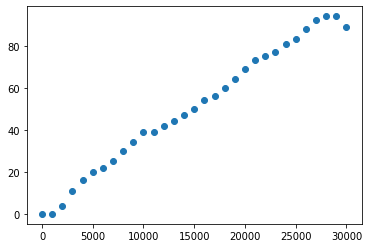

In [56]:
scatter(xs, idists)

In [57]:
import random
from scipy.stats import linregress

In [58]:
sample_size = 50
d1 = []
item_distance = []
s1 = random.sample(list(range(len(data))), sample_size)
s2 = random.sample(list(range(len(data))), sample_size)

In [59]:
# Abstract distance
for f1, f2 in zip(s1, s2):
    # Frame distance
    d1.append(abs(f1 - f2))
    # Item Symmetric Set Distance
    frame1 = data[f1, :]
    frame2 = data[f2, :]
    item_distance.append(itemset_distance(abstractify_items(frame1), abstractify_items(frame2)))

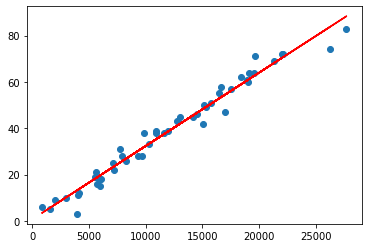

In [60]:
scatter(d1, item_distance)
m, b, r, p, stderr = linregress(np.array(d1), np.array(item_distance))
plt.plot(np.array(d1), m * np.array(d1) + b, c="r")

In [61]:
r, p

(0.9854402390618382, 1.347208136024567e-38)

In [62]:
all_items = item_set.ItemSet(sm_global.all_things)

In [63]:
hex(rooms["Landing_Site"].mem_address)

'0x791f8'

In [64]:
def get_room_index(frame):
    a = data_int8[frame, 0x079b]
    b = data_int8[frame, 0x079c]
    return (b << 8) + a

In [65]:
from rom_tools.address import Address

In [96]:
def frame_to_position(frame, items=None):
    if items is None:
        items = all_items
    room_address = get_room_index(frame)
    r = room_ref[room_address]
    # Choose arbitrarily the first node (TODO)
    pos = list(r.graph.name_node.keys())[0]
    return BFSState(pos, items)

In [72]:
def position_distance(p1, p2):
    # Choose arbitrarily the path p1 -> p2
    offers, finished, _, final_state = base_abs.BFS_optimized(p1, p2)
    if final_state is None:
        offers, finished, _, final_state = base_abs.BFS_optimized(p2, p1)
        if final_state is None:
            return float("inf")
        else:
            p = bfs_backtrack(p1, p2, offers)
            return len(p)
    else:
        p = bfs_backtrack(p1, p2, offers)
        return len(p)

In [73]:
p1 = frame_to_position(f1)
p2 = frame_to_position(f2)

In [74]:
map_distance = []

In [75]:
# Abstract distance
for f1, f2 in zip(s1, s2):
    # Map BFS Distance
    p1 = frame_to_position(f1)
    p2 = frame_to_position(f2)
    d = position_distance(p1, p2)
    map_distance.append(d)
    if d == float("inf"):
        print(p1, p2)

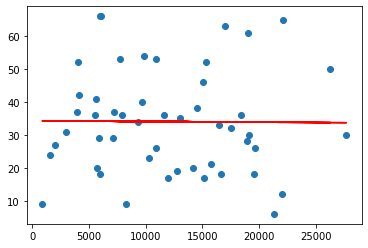

In [76]:
scatter(d1, map_distance)
m, b, r, p, stderr = linregress(np.array(d1), np.array(map_distance))
plt.plot(np.array(d1), m * np.array(d1) + b, c="r")

In [77]:
r, p

(-0.008854562048861835, 0.9513363158467876)

In [84]:
# Does it get more accurate as time progresses?
xs = []
ys = []
for f1, f2, d in zip(s1, s2, map_distance):
    start_frame = min(f1, f2)
    error = abs(m * abs(f1 - f2) + b - d)
    xs.append(start_frame)
    ys.append(error)

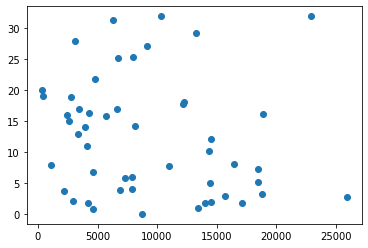

In [85]:
scatter(xs, ys)
# Seems like no:

In [100]:
map_item_distance = []

In [101]:
# Abstract Distance w/ items
for i, (f1, f2) in enumerate(zip(s1, s2)):
    print(i)
    # Map BFS Distance
    i1, _ = abstractify_items(data[f1, :])
    p1 = frame_to_position(f1, i1)
    i2, _ = abstractify_items(data[f2, :])
    p2 = frame_to_position(f2, i2)
    d = position_distance(p1, p2)
    map_item_distance.append(d)
    if d == float("inf"):
        print(p1, p2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


KeyboardInterrupt: 

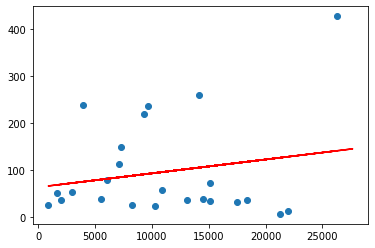

In [105]:
scatter(d1[:24], map_item_distance)
m, b, r, p, stderr = linregress(np.array(d1[:24]), np.array(map_item_distance))
plt.plot(np.array(d1), m * np.array(d1) + b, c="r")

In [ ]:
r, p